### A dynamic threshold decision system for stock trading signal detection
- PLR 코드 구현
- Trading Signals Generation 구현

In [1]:
# package import
import numpy as np
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import FinanceDataReader as fdr

In [2]:
# compute_error functions
def interpolate(sequence, seq_range):
    """Return (x0,y0,x1,y1) of a line fit to a segment using a simple interpolation"""
    return (seq_range[0], sequence[seq_range[0]], seq_range[1], sequence[seq_range[1]])

def draw_plot(data, plot_title):
    plot(range(len(data)),data,alpha=0.8)
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for idx, segment in enumerate(segments):
        if segment[1] - segment[3] > 0: # Down
            line = Line2D((segment[0],segment[2]),(segment[1],segment[3]), linestyle='--', color='green')
        elif segment[1] - segment[3] < 0: # Up
            line = Line2D((segment[0],segment[2]),(segment[1],segment[3]), linestyle='-', color='green')
        ax.add_line(line)

In [3]:
# 삼성전가 주가 데이터 가져오기
df = fdr.DataReader('005930', '2018')
df = df.reset_index()
df['NextClose'] = df['Close'].shift(-1)

dff = df.copy()
dff.dropna(inplace=True)
data = list(dff['Close'].values)

### PLR
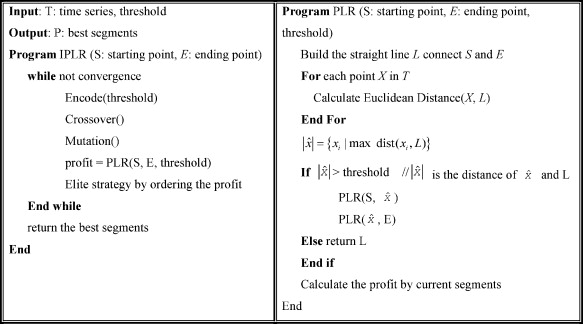

In [4]:
def PLR(sequence, create_segment, max_error, seq_range=None):
    if not seq_range:
        seq_range = (0,len(sequence)-1)
        
    start = seq_range[0]
    end = seq_range[1]
    
    result_segment = create_segment(sequence,(seq_range[0],seq_range[1])) # x0,y0,x1,y1
    
    y1 = np.array(sequence[seq_range[0]:seq_range[1]+1])
    
    x_c = (result_segment[0], result_segment[2])
    y_c = (result_segment[1], result_segment[3])
    
    A = np.vstack([x_c, np.ones(len(x_c))]).T

    m, c = np.linalg.lstsq(A, y_c)[0]
    
    x = np.arange(seq_range[0],seq_range[1]+1)

    data_L = m * np.array(x) + c
    
    x_hat, max_dist = np.argmax(np.abs(y1-data_L)), np.max(np.abs(y1-data_L)) # 가장 먼 거리의 y 값, max 거리
    x_hat = start + x_hat

    if  max_dist < max_error:
        return [result_segment]
    else:
        return PLR(sequence, create_segment, max_error, (start,x_hat)) + PLR(sequence, create_segment, max_error, (x_hat,end))
        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


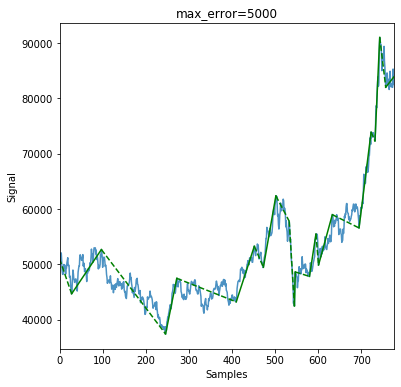

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


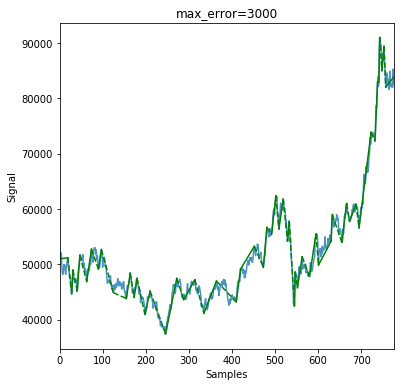

In [10]:
max_error = 5000
figure(figsize=(6,6))
segments = PLR(data, interpolate, max_error)
draw_plot(data, 'max_error='+str(max_error))
draw_segments(segments)
show()

max_error2 = 3000
figure(figsize=(6,6))
segments2 = PLR(data, interpolate, max_error2)
draw_plot(data, 'max_error='+str(max_error2))
draw_segments(segments2)
show()

In [11]:
print("============== segments ==============")
print("(s_index, s_close, e_index, e_close)")
segments

============== segments ==============
(s_index, s_close, e_index, e_close)


[(0, 51020, 28, 44700),
 (28, 44700, 97, 52700),
 (97, 52700, 246, 37450),
 (246, 37450, 272, 47500),
 (272, 47500, 410, 43250),
 (410, 43250, 452, 53300),
 (452, 53300, 473, 49500),
 (473, 49500, 502, 62400),
 (502, 62400, 533, 57800),
 (533, 57800, 545, 42500),
 (545, 42500, 547, 48650),
 (547, 48650, 580, 47850),
 (580, 47850, 595, 55500),
 (595, 55500, 601, 49900),
 (601, 49900, 633, 59000),
 (633, 59000, 695, 56600),
 (695, 56600, 723, 73900),
 (723, 73900, 732, 72300),
 (732, 72300, 743, 91000),
 (743, 91000, 757, 82000),
 (757, 82000, 777, 84000)]

### Trading Signals Generation
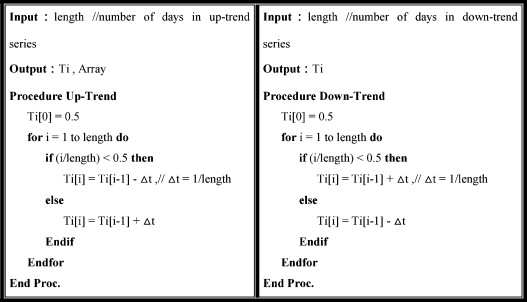

In [12]:
# 트렌드 라인에 대해서 시작 인덱스, 끝 인덱스, 길이, 매수/매도 표시
trend = np.zeros((len(segments), 4))
for idx, segment in enumerate(segments):
    if segment[1] - segment[3] > 0: # Down
        trend[idx] = [segment[0], segment[2], np.abs(segment[0]-segment[2]), 0] # 시작, 끝, 길이, 매수/매도
    elif segment[1] - segment[3] < 0: # Up
        trend[idx] = [segment[0], segment[2], np.abs(segment[0]-segment[2]), 1] # 시작, 끝, 길이, 매수/매도
        
# 생성된 up-trend series, down-trend series 타입별로 trading signal 계산
TT = []
min_max_TT = []
for idx, val in enumerate(trend): # Down::
    if trend[idx][3] == 0:
                
        length = int(trend[idx][2])
        T = np.zeros(length)
        
        delta_t = 1/length
        
        T[0] = 0.5
        
        for i in range(1, length):
            if i/length < 0.5:             
                T[i] = T[i-1] - delta_t           
            else:
                T[i] = T[i-1] + delta_t
                
        max_T = np.argmax(T)
        min_T = np.argmin(T)
        
        if (T[max_T] == 0.5) | (T[min_T] == 0.5): # 기준이 되는 0.5는 고려하지 않음
            pass
        else:
            min_max_TT.append([int(trend[idx][0])+max_T, T[max_T], 1])
            min_max_TT.append([int(trend[idx][0])+min_T, T[min_T], 0])
                
        for j in range(len(T)):
            TT.append(T[j])
        
    elif trend[idx][3] == 1: # Up::
        
        length = int(trend[idx][2])
        T = np.zeros(length)
        
        delta_t = 1/length
        
        T[0] = 0.5
        
        for i in range(1, length):
            if i/length < 0.5:
                T[i] = T[i-1] + delta_t
            else:
                T[i] = T[i-1] - delta_t
                
        max_T = np.argmax(T)
        min_T = np.argmin(T)
        
        if (T[max_T] == 0.5) | (T[min_T] == 0.5):
            pass
        else:
            min_max_TT.append([int(trend[idx][0])+max_T, T[max_T], 1])
            min_max_TT.append([int(trend[idx][0])+min_T, T[min_T], 0])              
                
        for j in range(len(T)):
            TT.append(T[j])        

<Figure size 432x288 with 0 Axes>

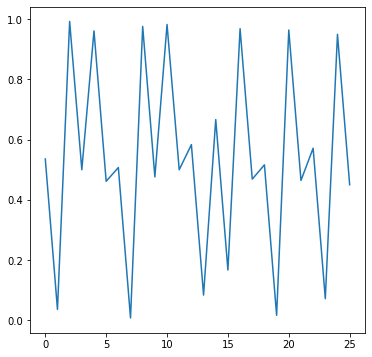

In [15]:
lst_idx, lst_val = [min_max_TT[i][0] for i in range(len(min_max_TT)) ], [min_max_TT[i][1] for i in range(len(min_max_TT)) ]

# trading signal
from matplotlib import pyplot as plt
plt.figure()
plt.figure(figsize=(6,6))
plt.plot(lst_val)
plt.show()

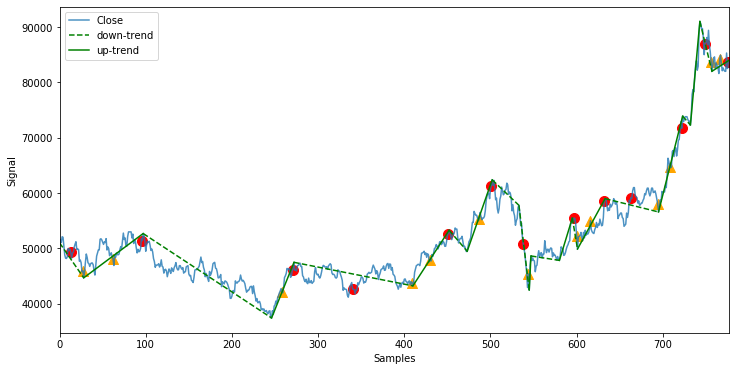

In [16]:
# 결과
plt.figure(figsize=(12,6))

plot(range(len(data)),data,alpha=0.8)
xlabel("Samples")
ylabel("Signal")
xlim((0,len(data)-1))

ax = gca()
for idx, segment in enumerate(segments):
    if segment[1] - segment[3] > 0: # Down
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]), linestyle='--', color='green')
    elif segment[1] - segment[3] < 0: # Up
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]), linestyle='-', color='green')
    ax.add_line(line)
      
for i in range(len(lst_val)):
    if lst_val[i] > 0.5: # 매도
        ax.scatter(lst_idx[i], data[lst_idx[i]], color='orange', marker='^', s=100)
    elif lst_val[i] < 0.5: # 매수
        ax.scatter(lst_idx[i], data[lst_idx[i]], color='red', s=100)
    
ax.legend(['Close','down-trend','up-trend'])